# Notebook Overview

In this notebook, you will decompress the trainig data and extract the data labels (M, F, Left, Right, Thumb, Index, Middle, Ring, Little) from the image filenames. You will create a training, validation and test dataset along with a sequential model graph. Lastly you will train, score and save the model off for later use.

1. Setup the software requirements
1. Prepare the image for training
1. Define, compile and train a model
1. Test the trained model and score it's accuracy

# Setup

## Install Requirements

In [1]:
!pip install -r ../../../requirements.txt -q

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


## Import modules 

In [2]:
# used for the datasets
import numpy as np
import pandas as pd
# to plot the data
import seaborn as sns
import tensorflow as tf

import os
import cv2
import random

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

# Data Prep

## Decompress training data

In [3]:
!tar -xJf ../compressed_data/fingerprint_altered_easy.tar.xz -C ../data 

## View a sample of the data

In [4]:
# Importing image data into Numpy arrays
img = mpimg.imread('../data/fingerprint_altered_easy/1__M_Left_index_finger_CR.BMP')
print(img)

[[160 160 160 ...   0   0   0]
 [160 105 105 ...   0   0   0]
 [160 105 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


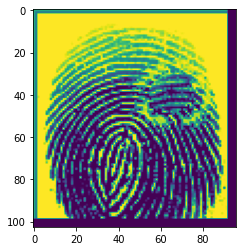

In [5]:
# Plotting numpy arrays as images
imgplot = plt.imshow(img)

In [6]:
# resize the image to 96x96
# img.thumbnail((96, 96)) #resizes the image

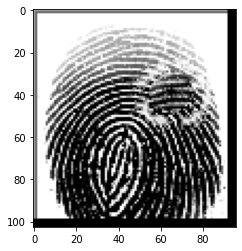

In [7]:
# Plotting numpy arrays as images
imgplot = plt.imshow(img, cmap="gray")

## Create function to extract labels from file names

In [8]:
def extract_label(img_path,train = True):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')
    
    if train:
        gender, lr, finger, _, _ = etc.split('_')
    else:
        gender, lr, finger, _ = etc.split('_')
    
    gender = 0 if gender == 'M' else 1
    lr = 0 if lr == 'Left' else 1

    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4
    
    return np.array([subject_id, gender, lr, finger], dtype=np.uint16)

## Create a function to load and resize images

In [102]:
img_size = 96


def loading_data(path, train):
    print("loading data from: ", path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),train)
            #print(f'label = {label}')
            data.append([label[1], img_resize ])
        except Exception as e:
            pass
    data
    return data

## Configure the data paths

In [103]:
Easy_path = "../data/fingerprint_altered_easy"
Easy_data = loading_data(Easy_path, train = True)

data = np.concatenate([Easy_data], axis=0, dtype=object)

loading data from:  ../data/fingerprint_altered_easy


In [99]:
Easy_data

[[0,
  array([[160, 158, 158, ...,   0,   0,   0],
         [160, 105, 121, ...,   0,   0,   0],
         [160, 105, 255, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
 [0,
  array([[160, 158, 158, ...,   0,   0,   0],
         [160, 105, 121, ...,   0,   0,   0],
         [160, 105, 255, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
 [0,
  array([[160, 158, 158, ...,   0,   0,   0],
         [160, 105, 121, ...,   0,   0,   0],
         [160, 105, 255, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
 [0,
  array([[160, 158, 158, ...,   0,   0,   0],
         [160, 1

## Create a complete array with label and feature

In [11]:
X, y = [], []

for label, feature in data:
    X.append(feature)
    y.append(label)
    
#del data

X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0

y = np.array(y)

In [12]:
# print the first record in the new array
print(data[0])

[0 array([[160, 158, 158, ...,   0,   0,   0],
          [160, 105, 121, ...,   0,   0,   0],
          [160, 105, 255, ...,   0,   0,   0],
          ...,
          [  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)]


## Split the data into train and validation

In [13]:
#train_test_split function helps us create our training data and test data from a single dataset
X_train, X_test, y_train, y_test = train_test_split(
    # input data
    X, 
    # target data
    y, 
    # size of the test dataset
    test_size=0.2, 
    # a "seed" that initializes the psuedorandom number generator
    random_state=42, 
    # controls whether the input dataset is randomly shuffled before being split
    shuffle=True, 
    # controls if the data are split in a stratified fashion
    stratify=None
)

# The output objects are Numpy arrays.

## Describe the arrays

In [14]:
print("Full dataset:  ",X.shape)
#del X, y
print("Train split:      ",X_train.shape)
print("Traing target:       ",y_train.shape)
print("Test split:      ",X_test.shape)
print("Test target:       ",y_test.shape)

Full dataset:   (17931, 96, 96, 1)
Train split:       (14344, 96, 96, 1)
Traing target:        (14344,)
Test split:       (3587, 96, 96, 1)
Test target:        (3587,)


# Modeling

Model Training APIs
1. Define the model architecture
1. Complile the model with the .compile API, which onfigures the model for training
1. Train or Fit the model with the .fit API, which trains the model for a fixed number of epochs (iterations on a dataset).
1. Predict with the model

## Define the model

In [15]:
# create a Sequential model
model = Sequential(name="fingerprint_prediction")

# incrementally create layers using the .add method
# Optionally, the first layer can receive an `input_shape` argument:
# start with the input shape equal to the fingerprint image size of 96x96x1
# we learn a total of 32 filters. 
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (96,96,1), name="layer1"))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', name="layer2"))
# Max pooling is then used to reduce the spatial dimensions of the output volume.
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout’s purpose is to help your network generalize and not overfit.
model.add(Dropout(0.25))

# We then learn 64 filters. Again max pooling is used to reduce the spatial dimensions.
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', name="layer3"))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', name="layer4"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "fingerprint_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (None, 96, 96, 32)        832       
                                                                 
 layer2 (Conv2D)             (None, 96, 96, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 layer3 (Conv2D)             (None, 48, 48, 64)        18496     
                                                                 
 layer4 (Conv2D)             (None, 48, 48, 64)        36928     
                                            

## Compile the model

First, we want to decide a model architecture, this is the number of hidden layers and activation functions, etc. (compile)

In [16]:
model_path = './model'

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    jit_compile=None
)

# Callbacks: utilities called at certain points during model training.
callbacks = [
    # Stop training when a monitored metric has stopped improving.
    EarlyStopping(monitor='val_acc', patience=20, mode='max', verbose=1),
    # Callback to save the Keras model or model weights at some frequency.
    ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, mode='max', verbose=1),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]

## Train the model

Secondly, we will want to train our model to get all the paramters to the correct value to map our inputs to our outputs. (fit)

In [17]:
# In Keras, callback records events into a History object.

epochs = 20
batch_size = 32
multi_proc = True

model.fit(
    # Input data
    x=X_train,
    # Target data
    y=y_train,
    # Number of samples per gradient update. 
    batch_size=batch_size,
    # Number of iterations to train the model. 
    epochs=epochs,
    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    verbose="auto",
    # This callback is automatically applied to every Keras model, then the History object gets returned by the fit method of models.
    callbacks=None,
    # Float between 0 and 1. Fraction of the training data to be used as validation data. 
    validation_split=0.1,
    # Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. Will override val_split
    validation_data=None,
    # whether to shuffle the training data before each epoch
    shuffle=True,
    # Optional dictionary mapping class indices (integers) to a weight (float) value
    class_weight=None,
    # Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
    sample_weight=None,
    # Epoch at which to start training (useful for resuming a previous training run).
    initial_epoch=0,
    # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
    steps_per_epoch=None,
    # Only relevant if validation_data is provided and is a tf.data dataset.
    validation_steps=None,
    # Number of samples per validation batch. If unspecified, will default to batch_size.
    validation_batch_size=None,
    # Only relevant if validation data is provided.
    validation_freq=1,
    # Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
    max_queue_size=10,
    # Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
    workers=4,
    # If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
    use_multiprocessing=multi_proc,
)

#TODO training can take up to 5 minutes per epoch on an AWS m5a.4xlarge, peaking around 16GiB and 10CPU

Epoch 1/20
404/404 [==============================] - 295s 726ms/step - loss: 0.5101 - accuracy: 0.7941 - val_loss: 0.4638 - val_accuracy: 0.7951
Epoch 2/20
404/404 [==============================] - 292s 722ms/step - loss: 0.4765 - accuracy: 0.7960 - val_loss: 0.4582 - val_accuracy: 0.7951
Epoch 3/20
404/404 [==============================] - 292s 724ms/step - loss: 0.4577 - accuracy: 0.7960 - val_loss: 0.4459 - val_accuracy: 0.7951
Epoch 4/20
404/404 [==============================] - 293s 725ms/step - loss: 0.4441 - accuracy: 0.7960 - val_loss: 0.4293 - val_accuracy: 0.7951
Epoch 5/20
404/404 [==============================] - 293s 724ms/step - loss: 0.4296 - accuracy: 0.7980 - val_loss: 0.4059 - val_accuracy: 0.8056
Epoch 6/20
404/404 [==============================] - 292s 723ms/step - loss: 0.3977 - accuracy: 0.8099 - val_loss: 0.3757 - val_accuracy: 0.8181
Epoch 7/20
404/404 [==============================] - 292s 724ms/step - loss: 0.3593 - accuracy: 0.8225 - val_loss: 0.3853 -

## Evaluate the model

Returns the loss value & metrics values for the model in test mode.

In [18]:
type(X_test)
X_test[0].shape

(96, 96, 1)

In [19]:
batch_size = None
workers = 1
multi_proc = False

score = model.evaluate(
    # Input data. 
    x=X_test,
    # Target data.
    y=y_test,
    # Number of samples per batch of computation. 
    batch_size=batch_size,
    # "auto", 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = single line.
    verbose="auto",
    # Optional Numpy array of weights for the test samples, used for weighting the loss function.
    sample_weight=None,
    # Total number of steps (batches of samples) before declaring the evaluation round finished.
    steps=None,
    # List of callbacks to apply during evaluation.
    callbacks=None,
    # Maximum size for the generator queue. 
    max_queue_size=10,
    # Maximum number of processes to spin up when using process-based threading. Default is 1.
    workers=workers,
    # use process-based threading
    use_multiprocessing=False,
    # If True, loss and metric results are returned as a dict, with each key being the name of the metric. If False, they are returned as a list.
    return_dict=False
)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

113/113 [==============================] - 14s 128ms/step - loss: 0.1636 - accuracy: 0.9601
Test loss: 0.1636316180229187
Test accuracy: 0.9601337909698486


# Save the model

There are two formats you can use to save an entire model to disk: the TensorFlow SavedModel format, and the older Keras H5 format.

In [20]:
# older Keras H5 format
model.save('model.h5')

In [21]:
# TensorFlow SavedModel format
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


## Cleanup 

In [22]:
# !rm -rf ../data/*

In [23]:
# !rm -rf .ipynb_checkpoints/

# Predict against data

Lastly, we will want to use this model to do some feed-forward passes to predict novel inputs. (predict). Generates output predictions for the input samples.

## Load the trained model

In [89]:
fingerprint_model = load_model('model.h5')

## Decompress the real data

In [90]:
# !tar -xJf ../compressed_data/fingerprint_real.tar.xz -C ../data

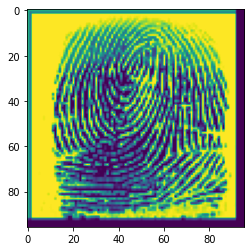

In [91]:
# img = mpimg.imread('../data/fingerprint_altered_easy/1__M_Left_index_finger_CR.BMP')

img_array = cv2.imread('../data/fingerprint_real/103__F_Left_index_finger.BMP', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(img_array, (img_size, img_size))

imgplot = plt.imshow(img_resize)

In [92]:
image_index = 0
print(img_resize.shape)
print(type(img_resize))
# print(img_resize)
img_resize.resize(1, 96, 96, 1)
np.random.rand(3,2)
myimg = np.random.rand(96, 96, 1)
myimg = np.random.randint(255, size=(1, 96, 96, 1), dtype=int)
print(myimg.shape)
print(type(myimg))
# print(myimg)

print(type(X_test))
print(X_test[0:1].shape)
# print(X_test[0:1])

(96, 96)
<class 'numpy.ndarray'>
(1, 96, 96, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1, 96, 96, 1)


In [93]:
#
# Load the real dataset.
#
Real_path = "../data/fingerprint_real"
Real_data = loading_data(Real_path, train = False)

real_data = np.concatenate([Real_data], axis=0, dtype=object)

X, y = [], []

#
# Separate the labels and features.
#
for label, feature in data:
    X.append(feature)
    y.append(label)

#
# Convert the real list to numpy then reshape and normalize.
#
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0

#
# Convert the labels list to a numpy array.
#
y = np.array(y)

print(f'Real image count = {data.shape[0]}')
print(f'Real array shape = {X.shape}')

loading data from:  ../data/fingerprint_real
Real image count = 17931
Real array shape = (17931, 96, 96, 1)


In [94]:
prediction = fingerprint_model.predict(
    # Input samples. 
    x = X[20:25],
    batch_size=None,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
print(f'Real dataset labels = {y[20:25]}')
print(f'Real dataset predictions = {prediction}')


1/1 [==============================] - 0s 118ms/step
Real dataset labels = [0 0 1 0 1]
Real dataset predictions = [[0.000000]
 [0.000000]
 [0.850394]
 [0.000000]
 [0.876932]]


In [95]:
def single_prediction(img_array):
    prediction = fingerprint_model.predict(
        x=img_array,
        batch_size=None,
        verbose="auto",
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False
    )
    return prediction

In [96]:
#
# Make a prediction from a single image file.
#
F_Left_index = cv2.imread('../data/fingerprint_real/103__F_Left_index_finger.BMP', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(F_Left_index, (img_size, img_size))
img_resize.resize(1, 96, 96, 1)
print(f'Prediction = {single_prediction(img_resize)}')

F_Left_index = cv2.imread('../data/fingerprint_real/275__F_Left_index_finger.BMP', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(F_Left_index, (img_size, img_size))
img_resize.resize(1, 96, 96, 1)
print(f'Prediction = {single_prediction(img_resize)}')

M_Right_index = cv2.imread('../data/fingerprint_real/232__M_Right_index_finger.BMP', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(M_Right_index, (img_size, img_size))
img_resize.resize(1, 96, 96, 1)
print(f'Prediction = {single_prediction(img_resize)}')

M_Right_index = cv2.imread('../data/fingerprint_real/504__M_Right_index_finger.BMP', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(M_Right_index, (img_size, img_size))
img_resize.resize(1, 96, 96, 1)
print(f'Prediction = {single_prediction(img_resize)}')

1/1 [==============================] - 0s 99ms/step
Prediction = [[1.000000]]
1/1 [==============================] - 0s 30ms/step
Prediction = [[1.000000]]
1/1 [==============================] - 0s 29ms/step
Prediction = [[0.000000]]
1/1 [==============================] - 0s 31ms/step
Prediction = [[0.000000]]


In [97]:
F_Left_index = cv2.imread('../data/fingerprint_real/103__F_Left_index_finger.BMP', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(F_Left_index, (img_size, img_size))
img_resize.resize(1, 96, 96, 1)
print(f'Prediction = {single_prediction(img_resize)}')

1/1 [==============================] - 0s 31ms/step
Prediction = [[1.000000]]


In [98]:
F_Left_index = cv2.imread('../data/fingerprint_real/275__F_Left_index_finger.BMP', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(F_Left_index, (img_size, img_size))
img_resize.resize(1, 96, 96, 1)
print(f'Prediction = {single_prediction(img_resize)}')

1/1 [==============================] - 0s 29ms/step
Prediction = [[1.000000]]
